<a href="https://colab.research.google.com/github/abhiraman/Capstone_Project/blob/main/Clubbed_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Syncing With GitHub


In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
# Clone the entire repo.
!git clone -l -s git://github.com/abhiraman/Capstone_Project  cloned-repo
%cd cloned-repo
!ls

fatal: could not create work tree dir 'cloned-repo': Operation not supported
[Errno 2] No such file or directory: 'cloned-repo'
/gdrive
MyDrive


In [3]:
!pip install import-ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=d0b1fd67842cf0a92c073afc318caff331d9e0579a2364b7ecbba2e807d70636
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [4]:
import os
import random
from google.colab.patches import cv2_imshow
import cv2
import json
from pprint import pprint
import PIL as pl
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [5]:
%cd /gdrive/My Drive/Capstone_project_data/cloned-repo
!ls

/gdrive/My Drive/Capstone_project_data/cloned-repo
 Img2text				    Text_Detection_Detectron2.ipynb
 M_C_Transliteration_padded_version.ipynb  'Transliteration Model'
 NetFlix_Mining.ipynb			    utils
 README.md


In [ ]:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg


In [7]:
from detectron2.utils.visualizer import Visualizer

In [8]:
%cd /gdrive/My Drive/Capstone_project_data/Synthetic Train Set - Detection & Recognition
!ls

/gdrive/My Drive/Capstone_project_data/Synthetic Train Set - Detection & Recognition
Annotation  Images     Obj_config.yml  readme.txt
clone-repo  input.jpg  output	       train_crop_annot.txt


In [9]:
cfg = get_cfg()
cfg.merge_from_file("Obj_config.yml")
predictor = DefaultPredictor(cfg)

In [10]:
%cd /gdrive/My Drive/Capstone_project_data/Demo Folder/Demo Images
!ls

/gdrive/My Drive/Capstone_project_data/Demo Folder/Demo Images
0.jpg  1514.jpg  3067.jpg  3548.jpg  3574.jpg  4350.jpg


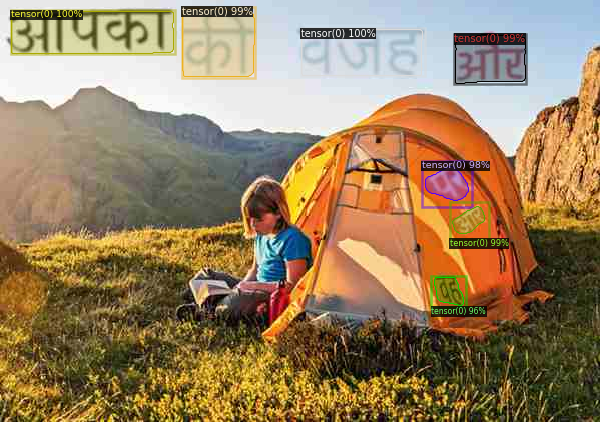

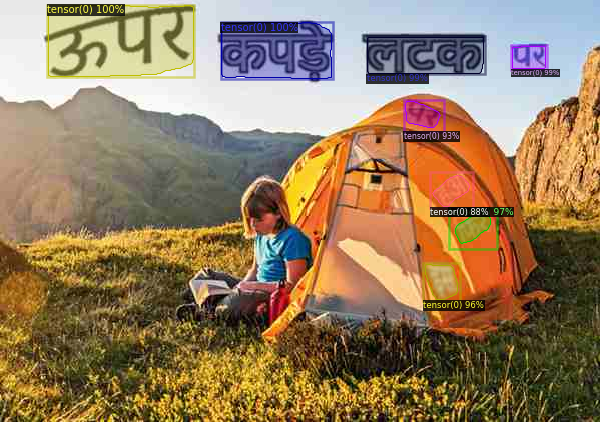

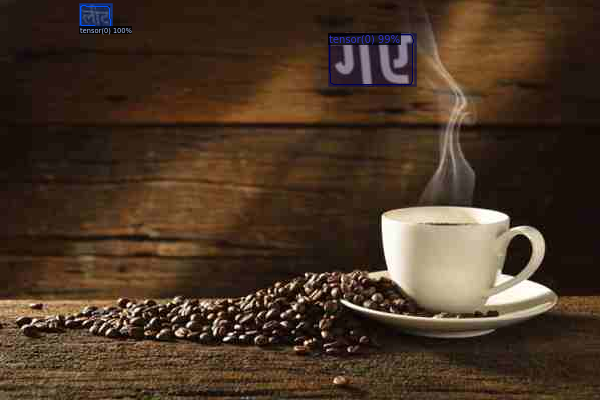

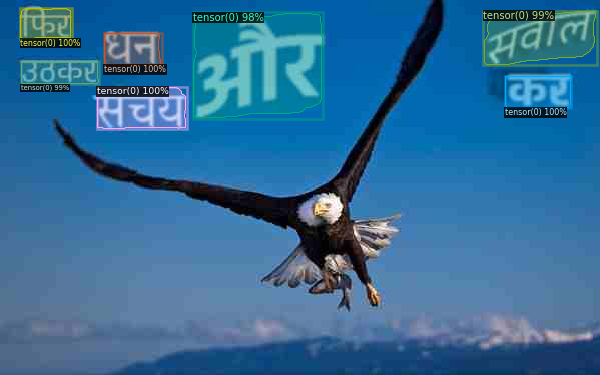

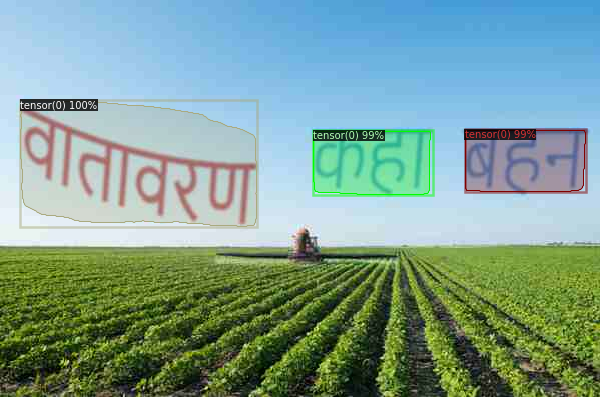

predBox_dims ---->   {'/gdrive/My Drive/Capstone_project_data/Demo Folder/Demo Images/3548.jpg': [[11.186222076416016, 175.21009826660156, 175.21009826660156, 11.186222076416016, 10.49257755279541, 10.49257755279541, 54.06877899169922, 54.06877899169922], [300.8085632324219, 425.21978759765625, 425.21978759765625, 300.8085632324219, 28.425777435302734, 28.425777435302734, 76.18428802490234, 76.18428802490234], [454.37860107421875, 526.1710815429688, 526.1710815429688, 454.37860107421875, 33.86711502075195, 33.86711502075195, 84.00060272216797, 84.00060272216797], [181.69818115234375, 255.21339416503906, 255.21339416503906, 181.69818115234375, 6.539129257202148, 6.539129257202148, 77.83626556396484, 77.83626556396484], [449.8235778808594, 488.6755065917969, 488.6755065917969, 449.8235778808594, 202.43731689453125, 202.43731689453125, 238.98362731933594, 238.98362731933594], [421.91632080078125, 472.2648620605469, 472.2648620605469, 421.91632080078125, 161.3211669921875, 161.321166992187

In [27]:
from detectron2.utils.visualizer import ColorMode
def _get_all_box_coords(x1,y1,x3,y3):
    x2 = x3
    x4 = x1
    y2 = y1
    y4=y3
    return [x1,x2,x3,x4,y1,y2,y3,y4]


def _infer_obj_detection(image_dir,image,predictor):   
  full_path = os.path.join(image_dir,image)
  inputs = cv2.imread(full_path)
  outputs = predictor(inputs)
  v = Visualizer(inputs[:, :, ::-1],metadata=None,scale=1,instance_mode=ColorMode.IMAGE_BW )  # remove the colors of unsegmented pixels. This option is only available for segmentation models
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
  return outputs["instances"]._fields["pred_boxes"].tensor.tolist()

imgDir = '/gdrive/My Drive/Capstone_project_data/Demo Folder/Demo Images'
infoDict = {}
for eImg in os.listdir(imgDir):
  predBox_dims = _infer_obj_detection(imgDir,eImg,predictor)
  for eBox_info in predBox_dims:
    x1,y1,x3,y3 = eBox_info
    allboxInfo = _get_all_box_coords(x1,y1,x3,y3)
    infoDict.setdefault(os.path.join(imgDir,eImg),[]).append(allboxInfo)

print("predBox_dims ---->  ",infoDict)
annotFolder = '/gdrive/My Drive/Capstone_project_data/Demo Folder'
json_file = "box_annot.json"
with open(os.path.join(annotFolder,json_file),'w') as fh:
  json.dump(infoDict,fh)
fh.close()

In [12]:
%cd /gdrive/My Drive/Capstone_project_data/cloned-repo
!ls

/gdrive/My Drive/Capstone_project_data/cloned-repo
 Img2text				    Text_Detection_Detectron2.ipynb
 M_C_Transliteration_padded_version.ipynb  'Transliteration Model'
 NetFlix_Mining.ipynb			    utils
 README.md


In [34]:
def _trim_validation_images(img_dir,infoDict,cropped_imgs_dir):
  counter=0  
  for e_image,boxList in infoDict.items():
    file_name = str(e_image.split('/')[-1].split('.')[0])
    if counter==1:break
    for ind,posList in enumerate(boxList):
        px = posList[0:4]
        py = posList[4:8]
        im = Image.open(e_image)
        crop_image = im.crop((px[0]+.75,py[0]+.75,px[2]+.75,py[2]+.75))
        data = np.asarray(crop_image)
        resize_img = cv2.resize(data,(128,128),fx=1,fy=2,interpolation=cv2.INTER_CUBIC)
        data = np.asarray(resize_img)
        _filter_bacground(data)
        
        new_img_path = os.path.join(cropped_imgs_dir,str(file_name),str(ind)+".jpg")
        new_img_path = r'{}'.format(new_img_path)
        print(cv2.imwrite(str(file_name)+str(ind)+".jpg",data))
        counter+=1



def _filter_bacground(img):
    #img = cv2.imread(img)
    gray  = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU|cv2.THRESH_BINARY)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    opening  = cv2.morphologyEx(thresh,cv2.MORPH_DILATE,kernel,iterations=3)
    opening  = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=3)

    result =cv2.GaussianBlur(opening,(1,1),0)
    result  = cv2.morphologyEx(result,cv2.MORPH_DILATE,kernel,iterations=3)
    cv2.cvtColor(result,cv2.COLOR_GRAY2RGB)
    cv2.addWeighted(result, 50., result, 0, 50.)

In [14]:
%cd '/gdrive/My Drive/Capstone_project_data/Demo Folder'
!ls

/gdrive/My Drive/Capstone_project_data/Demo Folder
 box_annot.json  'Demo Images'


In [35]:
parent_path = r'/gdrive/My Drive/Capstone_project_data/Demo Folder'
crop_Directory = os.path.join(parent_path,"cropped_images")
try:
  os.mkdir(crop_Directory)
except:
  os.rmdir(crop_Directory)
  os.mkdir(crop_Directory)

predFile = os.path.join(parent_path,json_file)
with open(predFile,'r') as fh:
  infoDict = json.load(fh)
%cd '/gdrive/My Drive/Capstone_project_data/Demo Folder/cropped_images'
_trim_validation_images(imgDir,infoDict,crop_Directory)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-4e2830973420>", line 12, in <module>
    get_ipython().magic("cd '/gdrive/My Drive/Capstone_project_data/Demo Folder/cropped_images'")
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-84>", line 2, in cd
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
FileNotFoundError: [Errno 2] No such file o

FileNotFoundError: ignored

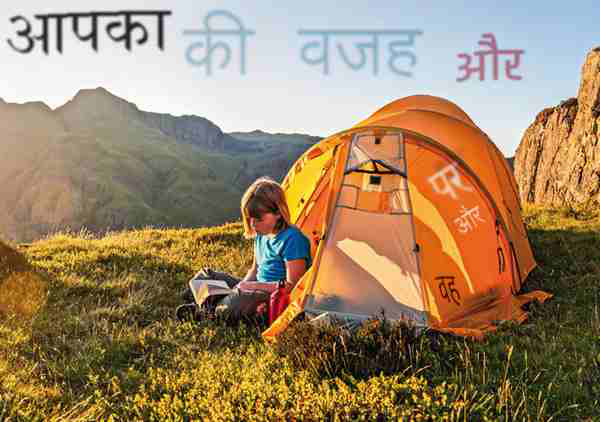

In [ ]:
im = Image.open(r"/gdrive/My Drive/Capstone_project_data/Demo Folder/Demo Images/3548.jpg")
display(im)